In [210]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

movies = pd.read_csv("/Users/talmageanderson/Desktop/Stat_486/mini1 data/movies.csv")

In [211]:
# Calculate the number of stars based on the number of '(' characters
movies['num_stars'] = movies['stars'].apply(lambda x: x.count('('))

# Convert all values in 'runtime' to strings, then remove ' min'
movies['runtime'] = movies['runtime'].astype(str).str.replace(' min', '', regex=False)

# Convert the cleaned 'runtime' column to numeric
movies['runtime'] = pd.to_numeric(movies['runtime'], errors='coerce')

# Fill missing values (if any) with the median or other appropriate value
movies['runtime'] = movies['runtime'].fillna(movies['runtime'].median())

# Ensure 'votes' column is treated as strings, then remove commas
movies['votes'] = movies['votes'].astype(str).str.replace(',', '', regex=True)

# Convert the cleaned 'votes' column back to numeric
movies['votes'] = pd.to_numeric(movies['votes'], errors='coerce')

# Fill missing values (if any) with 0 or an appropriate default
movies['votes'] = movies['votes'].fillna(0)


In [212]:
# Remove '$' and 'M', then convert to numeric and multiply by 1,000,000
movies['gross_earn'] = (
    movies['gross_earn']
    .str.replace('$', '', regex=False)  # Remove dollar sign
    .str.replace('M', '', regex=False)  # Remove 'M'
    .astype(float)                      # Convert to float
    * 1_000_000                         # Multiply by 1,000,000
)

# Handle missing values (if any)
movies['gross_earn'] = movies['gross_earn'].fillna(0)

In [213]:
# Ensure all values in 'genre' are strings; replace NaN with an empty string
movies['genre'] = movies['genre'].fillna('').astype(str)

# 1. Split genres and create a list of all unique genres
movies['genre_list'] = movies['genre'].apply(lambda x: [g.strip() for g in x.split(',') if g])

# 2. Create a set of all unique genres
unique_genres = set(g for genres in movies['genre_list'] for g in genres)

# 3. One-hot encode genres
for genre in unique_genres:
    movies[f'genre_{genre}'] = movies['genre_list'].apply(lambda x: 1 if genre in x else 0)

# 4. Drop the extra columns
movies = movies.drop(columns=['genre_list'])

movies.head(5)

,poster,title,certificate,runtime,genre,rating,about,director,stars,votes,...,genre_Sci-Fi,genre_Mystery,genre_Horror,genre_Musical,genre_Sport,genre_Drama,genre_War,genre_Fantasy,genre_Romance,genre_Action
0,https://m.media-amazon.com/images/S/sash/4Fyxw...,The Shawshank Redemption,15,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,"('Tim Robbins',), ('Morgan Freeman',), ('Bob G...",2626905,...,0,0,0,0,0,1,0,0,0,0
1,https://m.media-amazon.com/images/S/sash/4Fyxw...,The Dark Knight,12A,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,"('Christian Bale',), ('Heath Ledger',), ('Aaro...",2598173,...,0,0,0,0,0,1,0,0,0,1
2,https://m.media-amazon.com/images/S/sash/4Fyxw...,Inception,12A,148.0,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,Christopher Nolan,"('Leonardo DiCaprio',), ('Joseph Gordon-Levitt...",2304062,...,1,0,0,0,0,0,0,0,0,1
3,https://m.media-amazon.com/images/S/sash/4Fyxw...,Fight Club,18,139.0,Drama,8.8,An insomniac office worker and a devil-may-car...,David Fincher,"('Brad Pitt',), ('Edward Norton',), ('Meat Loa...",2071088,...,0,0,0,0,0,1,0,0,0,0
4,https://m.media-amazon.com/images/S/sash/4Fyxw...,Pulp Fiction,18,154.0,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",Quentin Tarantino,"('John Travolta',), ('Uma Thurman',), ('Samuel...",2011013,...,0,0,0,0,0,1,0,0,0,0


In [214]:
# Define a threshold for "good" vs. "bad" based on audience and critic metrics
threshold = 7.0  # Example threshold for rating
movies['is_good'] = movies['rating'].apply(lambda x: 1 if x >= threshold else 0)

# Select features and target
features = ['runtime', 'votes', 'gross_earn'] + [f'genre_{genre}' for genre in unique_genres]
X = movies[features]
y = movies['is_good']

X.head()

,runtime,votes,gross_earn,genre_Thriller,genre_Animation,genre_Comedy,genre_Western,genre_History,genre_Adventure,genre_Family,...,genre_Sci-Fi,genre_Mystery,genre_Horror,genre_Musical,genre_Sport,genre_Drama,genre_War,genre_Fantasy,genre_Romance,genre_Action
0,142.0,2626905,28340000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,152.0,2598173,534860000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,148.0,2304062,292580000.0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,139.0,2071088,37030000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,154.0,2011013,107930000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [217]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[592 128]
 [158 372]]
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       720
           1       0.74      0.70      0.72       530

    accuracy                           0.77      1250
   macro avg       0.77      0.76      0.76      1250
weighted avg       0.77      0.77      0.77      1250



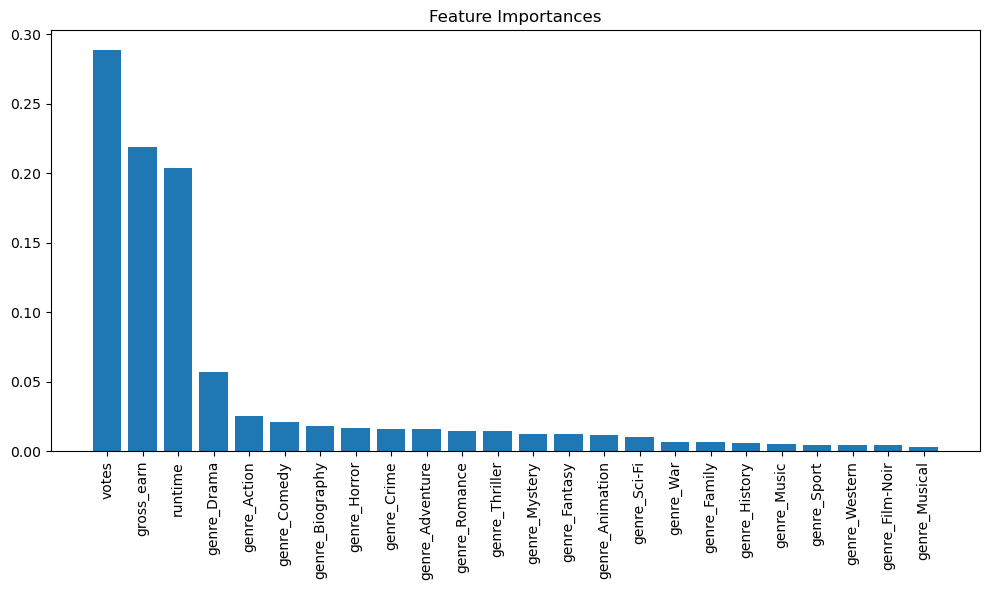

In [196]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [197]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores = cross_val_score(rf_model, X, y, cv=k, scoring='accuracy')

# Display results
print(f"Cross-validation scores for each fold: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")


Cross-validation scores for each fold: [0.477 0.604 0.61  0.674 0.663]
Mean accuracy: 0.6056
Standard deviation: 0.0700


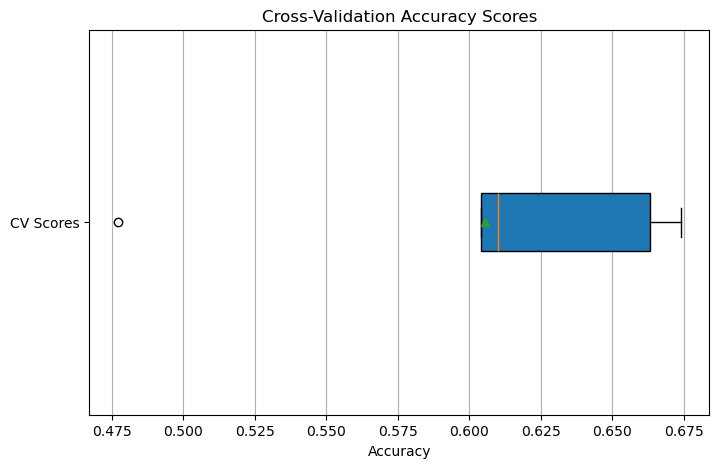

In [198]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.boxplot(cv_scores, vert=False, patch_artist=True, showmeans=True)
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Accuracy')
plt.yticks([1], ['CV Scores'])
plt.grid(axis='x')
plt.show()


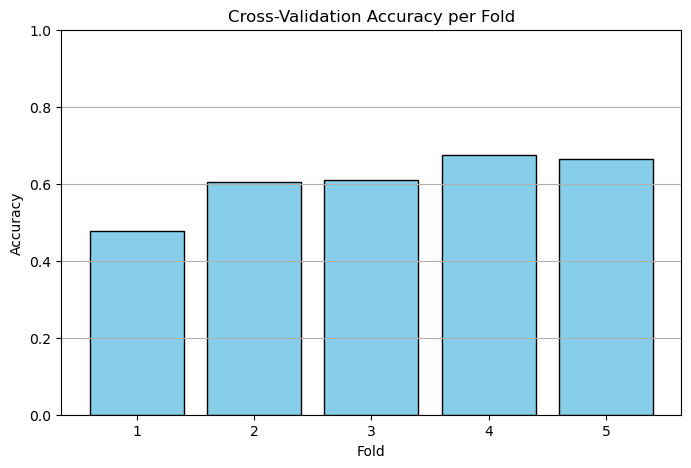

In [199]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, k + 1), cv_scores, color='skyblue', edgecolor='black')
plt.title('Cross-Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.xticks(range(1, k + 1))
plt.grid(axis='y')
plt.show()


In [204]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Features and target
X = movies[['runtime', 'rating', 'votes']]  # Use relevant features
y = movies['gross_earn']

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Outer loop: Split data for evaluation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = []

for train_idx, test_idx in outer_cv.split(X_scaled, y_scaled):
    # Split data
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]
    
    # Inner loop: Hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Best model from inner loop
    best_model = grid_search.best_estimator_
    
    # Evaluate on the test set of the outer loop
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)),
                             scaler_y.inverse_transform(y_pred.reshape(-1, 1)))
    nested_scores.append(mse)

# Average performance across folds
print(f"Nested CV Mean MSE: {np.mean(nested_scores)}")
print(f"Nested CV Std MSE: {np.std(nested_scores)}")


Nested CV Mean MSE: 2106612417773827.2
Nested CV Std MSE: 222248868134991.3


In [206]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=50, cv=inner_cv, random_state=42, scoring='neg_mean_squared_error'
)
randomized_search.fit(X_train, y_train)


/Users/talmageanderson/anaconda3/envs/dnn/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error')